# Full changesets

## Goals
- Come up with a list of taggers that will make the model an effective flagger

## Workflow
- Download the latest 1000 reviewed changesets from osm full features
- Use the 500 (250 harmful and 250 not harmful) as the training set and the other for testing.
- For every harmful changeset, understand why it was harmful
    - Convert why the changeset was harmful into a feature
- Train a model with the feature
- Predict label for other 500 changesets

## Notes
- Try a lot of taggers - 100 or even a 1000
- What taggers when used by gabbar has the best performance

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks")

# 1. Extract 500 harmful and not harmful changesets

In [3]:
changesets = pd.read_csv('changesets.csv')

# Changesets come up multiple times when they have multiple labels.
changesets = changesets.drop_duplicates('ID')

# Convert date from a string to a datetime object.
changesets['date'] = pd.to_datetime(changesets['date'])

print(changesets.shape)
changesets.head(2)

(59247, 19)


,ID,user,editor,Powerfull Editor,comment,source,imagery used,date,reasons,reasons__name,create,modify,delete,bbox,is suspect,harmful,checked,check_user__username,check date
0,47491144,RichRico,JOSM/1.5 (11639 en),True,Adding junction nodes or bridges to overlappin...,Bing,Not reported,2017-04-05 22:46:26,NaN,NaN,0.0,1.0,0.0,"SRID=4326;POLYGON ((-46.8202964 -23.693203, -4...",False,False,True,calfarome,2017-04-05T23:30:53.776282+00:00
1,47490912,Birgitta_fi,rosemary v0.4.4,False,Modified via wheelmap.org,Not reported,Not reported,2017-04-05 22:27:45,23.0,Major name modification,5.0,41.0,0.0,"SRID=4326;POLYGON ((24.9182827 60.1779368, 24....",False,True,True,yurasi,2017-04-05T23:33:08.813791+00:00


In [4]:
# Sort changesets by id with the lateset first.
changesets = changesets.sort('ID', ascending=False)

In [5]:
harmful_changesets = changesets[changesets['harmful'] == True]
print('Number of harmful changesets: {}'.format(harmful_changesets.shape[0]))

# Write some recent harmful changeset IDs to a file.
harmful_changesets = harmful_changesets[:500]

Number of harmful changesets: 5691


In [6]:
not_harmful_changesets = changesets[changesets['harmful'] == False]
print('Number of not harmful changesets: {}'.format(not_harmful_changesets.shape[0]))

# Write some recent not harmful changeset IDs to a file.
not_harmful_changesets = not_harmful_changesets[:500]

Number of not harmful changesets: 53556


In [7]:
merged_changesets = pd.concat([harmful_changesets, not_harmful_changesets])
merged_changesets[['ID', 'harmful']].to_csv('full-changeset-ids.csv', index=False)

!head -n5 ../data/full-changests/full-changeset-ids.csv

head: ../data/full-changests/full-changeset-ids.csv: No such file or directory


# 2. Download full changesets
- Ref: https://github.com/mapbox/osm-adiff-parser

# 3. ML on changesets with features

In [8]:
changesets = pd.read_csv('changesets-with-features.csv')
print(changesets.shape)
changesets.sample(5)

(949, 5)


,changeset_id,harmful,features_created,features_modified,features_deleted
47,47425982,True,0,1,0
652,47469780,False,517,76,30
882,47459620,False,0,1,0
97,47378219,True,5,0,0
444,46724899,True,5,0,0


In [9]:
harmful_changesets = changesets[changesets['harmful'] == True]
print('Changesets harmful: {}'.format(harmful_changesets.shape))


not_harmful_changesets = changesets[changesets['harmful'] == False]
print('Changesets harmful: {}'.format(not_harmful_changesets.shape))

Changesets harmful: (470, 5)
Changesets harmful: (479, 5)


In [10]:
from sklearn.cross_validation import train_test_split

# Feature matrix.
X = changesets.drop(['changeset_id', 'harmful'], axis=1)

# Target array.
y = changesets['harmful']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)
print('Training samples: {}'.format(Xtrain.shape[0]))
print('Testing samples: {}'.format(Xtest.shape[0]))

Training samples: 711
Testing samples: 238


/Users/bkowshik/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(Xtrain, ytrain);

# Get predictions.
ymodel = model.predict(Xtest)

In [12]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ymodel))

             precision    recall  f1-score   support

      False       0.80      0.20      0.32       122
       True       0.53      0.95      0.68       116

avg / total       0.67      0.56      0.49       238



In [13]:
# Evaluate a score by cross-validation.
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(model, X, y, cv=3)
np.mean(scores)

0.46686695708777731

/Users/bkowshik/anaconda/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


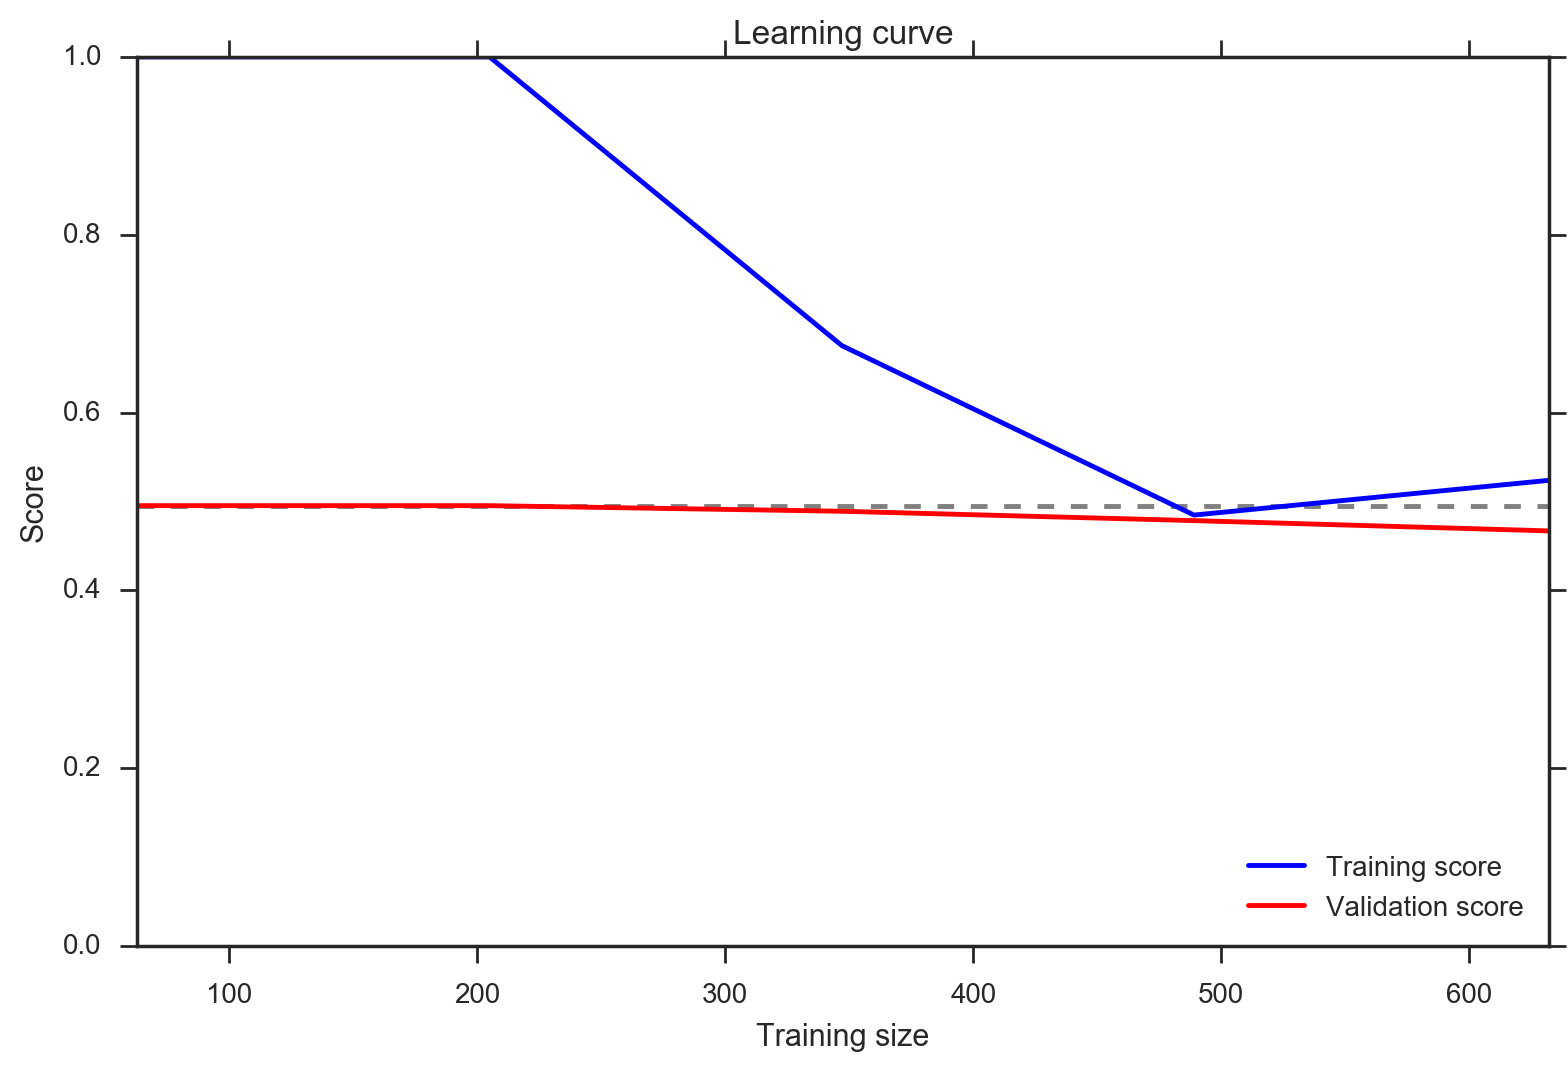

In [14]:
# Learning curve.
from sklearn.learning_curve import learning_curve

fig, ax = plt.subplots(1, 1)

N, train_lc, val_lc = learning_curve(model, X, y, cv=3, train_sizes=np.linspace(0.1, 1.0, 5))

ax.plot(N, np.mean(train_lc, 1), color='blue', label='Training score')
ax.plot(N, np.mean(val_lc, 1), color='red', label='Validation score')
ax.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray', linestyle='dashed')

ax.set_ylim(0, 1)
ax.set_xlim(N[0], N[-1])
ax.set_xlabel('Training size')
ax.set_ylabel('Score')
ax.set_title('Learning curve')
ax.legend(loc='lower right')

plt.tight_layout()